In [1]:
import pandas as pd
import pm4py


from pm4py.objects.log.importer.xes import importer as xes_importer
from pm4py.objects.conversion.log import converter as log_converter
from pm4py.statistics.traces.generic.log import case_statistics

import numpy as np
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, fcluster

In [2]:

# Data Import:
xes_path = "/Users/moritz_hawener/Documents/Work/Studium/Master/WS25/BPI/BPI Challenge 2017_1_all/BPI Challenge 2017.xes.gz"

# Read the XES log
event_log = xes_importer.apply(xes_path)

/opt/miniconda3/envs/bpi/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
parsing log, completed traces :: 100%|██████████| 31509/31509 [00:34<00:00, 920.25it/s] 


In [3]:
# Transform the event log to a pandas DataFrame
df = log_converter.apply(event_log, variant=log_converter.Variants.TO_DATA_FRAME)

In [4]:
roles = pm4py.discover_organizational_roles(
    df,
    resource_key='org:resource',
    activity_key='concept:name',
    timestamp_key='time:timestamp',
    case_id_key='case:concept:name'
)

In [5]:
roles

[Activities: ['A_Accepted', 'A_Complete', 'O_Create Offer', 'O_Created', 'O_Sent (mail and online)', 'W_Complete application'] Originators importance {'User_10': 10090, 'User_100': 39, 'User_101': 22, 'User_102': 57, 'User_103': 78, 'User_104': 2401, 'User_105': 1037, 'User_106': 60, 'User_107': 17, 'User_108': 586, 'User_109': 198, 'User_11': 3059, 'User_110': 75, 'User_111': 24, 'User_12': 4627, 'User_13': 2570, 'User_132': 1161, 'User_135': 192, 'User_14': 5479, 'User_141': 145, 'User_15': 5692, 'User_16': 5681, 'User_17': 4555, 'User_18': 7642, 'User_19': 5039, 'User_2': 5111, 'User_20': 1018, 'User_21': 4145, 'User_22': 1160, 'User_23': 2815, 'User_24': 5066, 'User_25': 1941, 'User_26': 2990, 'User_27': 3419, 'User_28': 8097, 'User_29': 222, 'User_3': 11443, 'User_30': 108, 'User_31': 2061, 'User_32': 4064, 'User_33': 1691, 'User_34': 1837, 'User_35': 5790, 'User_36': 4412, 'User_37': 6965, 'User_38': 4084, 'User_39': 5876, 'User_4': 6170, 'User_40': 5762, 'User_41': 6064, 'User_4

In [6]:
roles[0].__dict__


{'activities': ['A_Accepted',
  'A_Complete',
  'O_Create Offer',
  'O_Created',
  'O_Sent (mail and online)',
  'W_Complete application'],
 'originator_importance': {'User_10': 10090,
  'User_100': 39,
  'User_101': 22,
  'User_102': 57,
  'User_103': 78,
  'User_104': 2401,
  'User_105': 1037,
  'User_106': 60,
  'User_107': 17,
  'User_108': 586,
  'User_109': 198,
  'User_11': 3059,
  'User_110': 75,
  'User_111': 24,
  'User_12': 4627,
  'User_13': 2570,
  'User_132': 1161,
  'User_135': 192,
  'User_14': 5479,
  'User_141': 145,
  'User_15': 5692,
  'User_16': 5681,
  'User_17': 4555,
  'User_18': 7642,
  'User_19': 5039,
  'User_2': 5111,
  'User_20': 1018,
  'User_21': 4145,
  'User_22': 1160,
  'User_23': 2815,
  'User_24': 5066,
  'User_25': 1941,
  'User_26': 2990,
  'User_27': 3419,
  'User_28': 8097,
  'User_29': 222,
  'User_3': 11443,
  'User_30': 108,
  'User_31': 2061,
  'User_32': 4064,
  'User_33': 1691,
  'User_34': 1837,
  'User_35': 5790,
  'User_36': 4412,
  'Use

### Resource availability probabilities

In [7]:
#Extract resource availabillity from log
import json

def extract_resource_availability(df):
    
    # Extract temporal features
    df['weekday'] = df['time:timestamp'].dt.weekday
    df['hour'] = df['time:timestamp'].dt.hour
    
    # Count occurrences of each resource at each time slot
    # We normalize this to get a probability between 0 and 1
    availability = df.groupby(['org:resource', 'weekday', 'hour']).size().reset_index(name='counts')
    
    # Simple normalization: counts / max_counts_per_resource
    max_counts = availability.groupby('org:resource')['counts'].transform('max')
    availability['prob'] = availability['counts'] / max_counts
    
    # Convert to a dictionary for fast lookup: {(res, day, hour): prob}
    return availability.set_index(['org:resource', 'weekday', 'hour'])['prob'].to_dict()

def export_availability_to_json(availability_dict, filename="resource_availability.json"):
    # Convert tuple keys (res, day, hour) to string keys "res|day|hour" for JSON compatibility
    exportable_dict = {f"{k[0]}|{k[1]}|{k[2]}": v for k, v in availability_dict.items()}
    
    with open(filename, 'w') as f:
        json.dump(exportable_dict, f, indent=4)
    print(f"Successfully exported to {filename}")

In [8]:
avail_props = extract_resource_availability(df)
export_availability_to_json(avail_props)

Successfully exported to resource_availability.json


In [9]:
avail_props

{('User_1', 0, 0): 0.017890191239975324,
 ('User_1', 0, 1): 0.00987045033929673,
 ('User_1', 0, 2): 0.005552128315854411,
 ('User_1', 0, 3): 0.008019740900678593,
 ('User_1', 0, 4): 0.00987045033929673,
 ('User_1', 0, 5): 0.03701418877236274,
 ('User_1', 0, 6): 0.7538556446637877,
 ('User_1', 0, 7): 0.602508739461238,
 ('User_1', 0, 8): 0.22167386387003907,
 ('User_1', 0, 9): 0.2545753650010282,
 ('User_1', 0, 10): 0.26629652477894306,
 ('User_1', 0, 11): 0.27390499691548426,
 ('User_1', 0, 12): 0.31153608883405304,
 ('User_1', 0, 13): 0.28315854410857494,
 ('User_1', 0, 14): 0.2646514497223936,
 ('User_1', 0, 15): 0.22270203578038247,
 ('User_1', 0, 16): 0.2652683528685996,
 ('User_1', 0, 17): 0.2677359654534238,
 ('User_1', 0, 18): 0.3066008636644047,
 ('User_1', 0, 19): 0.29302899444787167,
 ('User_1', 0, 20): 0.26588525601480567,
 ('User_1', 0, 21): 0.25375282747275346,
 ('User_1', 0, 22): 0.19370758790869833,
 ('User_1', 0, 23): 0.09520871889779971,
 ('User_1', 1, 0): 0.0197409006

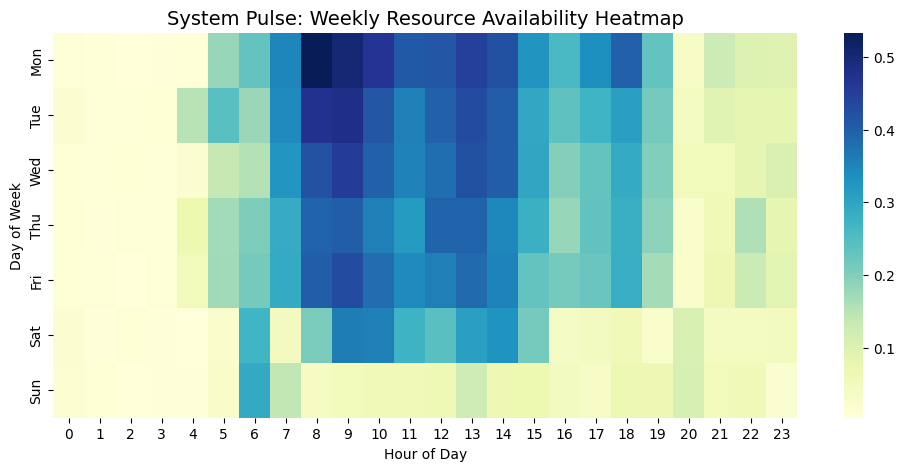

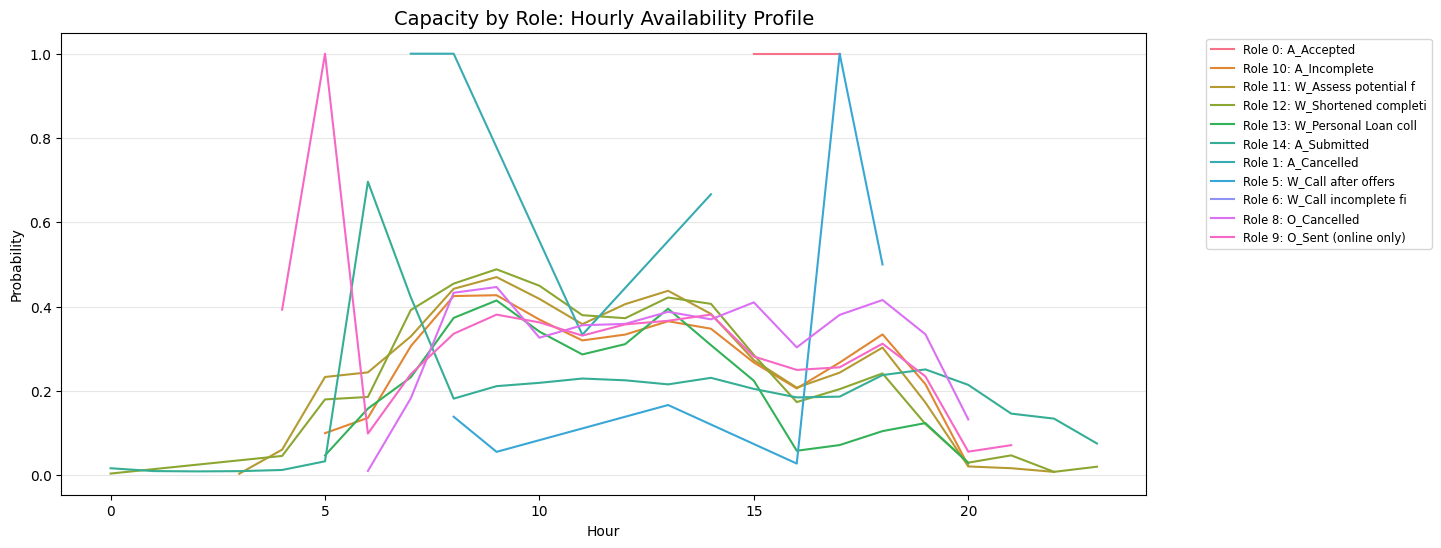

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def create_resource_visuals(roles, avail_props):
    # 1. Prepare Data
    data = []
    for (res, day, hour), prob in avail_props.items():
        data.append({'Resource': res, 'Weekday': day, 'Hour': hour, 'Probability': prob})
    avail_df = pd.DataFrame(data)

    # 2. Map Resources to Roles and create human-readable Role Names
    resource_to_role = {}
    role_names = {}
    
    for i, role in enumerate(roles):
        # Using the first activity in the list to give the role a descriptive name
        main_activity = role.activities[0] if role.activities else "Unknown"
        role_label = f"Role {i}: {main_activity[:20]}"
        role_names[i] = role_label
        
        # In your object, the resources are the keys in 'originator_importance'
        for res in role.originator_importance.keys():
            resource_to_role[res] = role_label
            
    avail_df['Role'] = avail_df['Resource'].map(resource_to_role)
    
    # --- CHART A: Heatmap ---
    heatmap_data = avail_df.groupby(['Weekday', 'Hour'])['Probability'].mean().unstack()
    heatmap_data = heatmap_data.reindex(index=range(7), columns=range(24), fill_value=0)
    
    plt.figure(figsize=(12, 5))
    sns.heatmap(heatmap_data, cmap='YlGnBu', 
                yticklabels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
    plt.title('Weekly Resource Availability Heatmap', fontsize=14)
    plt.xlabel('Hour of Day')
    plt.ylabel('Day of Week')
    plt.savefig('heatmap_weekly_rhythm.png', bbox_inches='tight', dpi=300)

    # --- CHART B: Grouped Bar Chart ---
    # Focus on the top 5 most active roles to keep the chart clean for a slide
    role_hourly = avail_df.groupby(['Role', 'Hour'])['Probability'].mean().reset_index()
    
    plt.figure(figsize=(14, 6))
    sns.lineplot(data=role_hourly, x='Hour', y='Probability', hue='Role')
    plt.title('Capacity by Role: Hourly Availability Profile', fontsize=14)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
    plt.grid(axis='y', alpha=0.3)
    plt.savefig('role_based_capacity.png', bbox_inches='tight', dpi=300)
    plt.show()

create_resource_visuals(roles, avail_props)